# [IAPR 2018:][iapr2018] Lab 3 ‒  Classification

**Author:** Mathieu LAMIOT, Sohyeong KIM

**Due date:** 25.05.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

The seperation curve between classes i and y is made up of the points x such as 
P(class=i|x)=P(class=j|x),

which can be written thanks to Bayes rule : 
P(x|class=i)P(class=i)=P(x|class=j)P(class=j).

Note that our training sets have the same size. Without further information, we will assume that P(class=i)=P(class=j) for all couples of classes (i,j).

Hence, we need to solve P(x|class=i)=P(x|class=j).

To simplify the formulas, we are gonna work on the following equations (that is equivalent) : ln(P(x|class=i))=ln(P(x|class=j))

In order to come up with a relevant model for the probabilities in this formula, we can visualize the data we are working on :

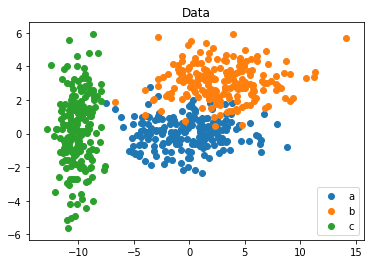

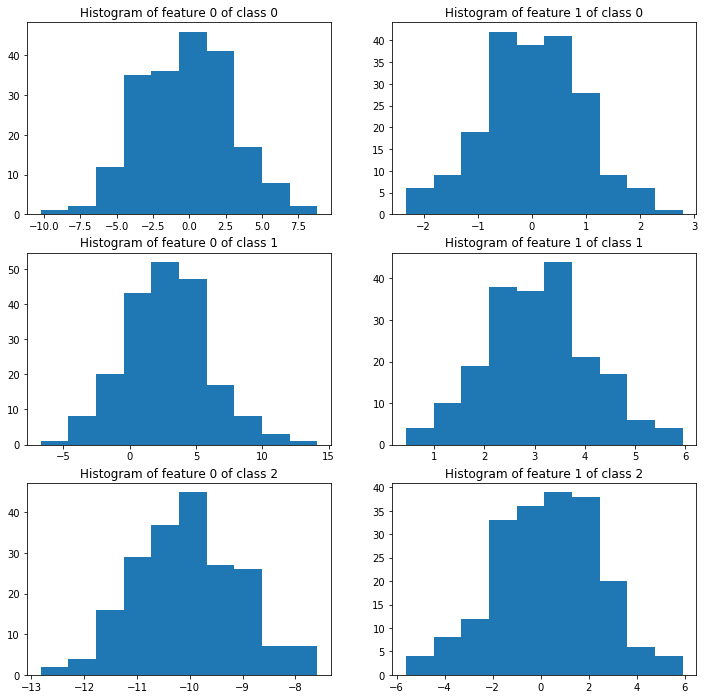

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

classes = [a,b,c]

#Display the datas
plt.scatter(a[:,0],a[:,1],label='a')
plt.title('Data')
plt.scatter(b[:,0],b[:,1],label='b')
plt.scatter(c[:,0],c[:,1],label='c')
plt.legend(loc=4)
plt.show()

#Display the histograms of each feature for each class
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for ClassID in range(0,3):
    Class = classes[ClassID];
    for feature in range(0,2):
        axes[ClassID,feature].hist(Class[:,feature])
        axes[ClassID,feature].set_title('Histogram of feature {} of class {}'.format(feature, ClassID))

Seeing those results, it seems reasonnable to assume that the datas follow normal distribution in each class. Hence, we can fit normal distributions on the data by computing means and covariance matrices (those results are rounded to the closest integers, as demanded).

In [4]:
from sympy import var, plot_implicit

#Compute the means and the covariance matrix for each class

means =[0,0,0];
covs = [0,0,0];
ClassID = 0
for Class in classes:
    N,temp = Class.shape;
    #MEAN
    xMean = 0;
    yMean = 0;
    for dataID in range(0,N):
        xMean = xMean + Class[dataID,0];
        yMean = yMean + Class[dataID,1];
    xMean = xMean/N;
    yMean = yMean/N;
    means[ClassID] = [round(xMean),round(yMean)];
    #means[ClassID] = [(xMean),(yMean)];
    #COVARIANCE MATRIX 
    cov = 0
    for dataID in range(0,N):
        vect = np.array([Class[dataID,0], Class[dataID,1]]-np.array([xMean, yMean]));
        cov = cov + np.outer(vect,np.transpose(vect))
    cov = (cov/N);
    cov[0,0] = round(cov[0,0])
    cov[1,1] = round(cov[1,1])
    cov[0,1] = round(cov[0,1]);
    cov[1,0] = round(cov[1,0]);

    covs[ClassID] = cov;
    ClassID = ClassID+1;    

We can then compute the discriminant functions fi:x->ln(P(x|class=i)). We will use those later to compare our results with different methods.

In [5]:
#Define the discriminant functions
import math

def BayesDiscriminant(data,mean,cov):
    covinv = np.linalg.inv(cov)
    diffMean = np.transpose(np.array([Class[dataID,0], Class[dataID,1]]-np.array([xMean, yMean])));
    score = -(1/2)*np.transpose(data).dot(covinv.dot(data)) \
            +(1/2)*np.transpose(data).dot(covinv.dot(mean)) \
            -(1/2)*np.transpose(mean).dot(covinv.dot(mean)) \
            +(1/2)*np.transpose(mean).dot(covinv.dot(data)) \
            + math.log(1/((1/2)*math.sqrt(np.linalg.det(cov))));
    return score

In the following cell, we are computing the discriminant functions with symbolics values (using sympy) to be able to solve the equations of the frontiers. Once they are solved, we plot the results along with the data.

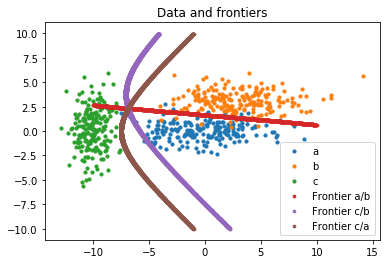

In [6]:
from sympy import var, plot_implicit, Eq, symbols, Or, plot
import sympy as syp

#------Compute the discriminant function with symbolic variables
x, y = symbols('x y')
score = [];
for ClassID in range(0,3):
    mean = np.array(means[ClassID])
    mean = np.array([mean[0],mean[1]])
    cov = covs[ClassID];
    covinv = np.linalg.inv(cov);
    data = np.array([x ,y])
    
    score.append(-(1/2)*np.transpose(data).dot(covinv.dot(data)) \
            +(1/2)*np.transpose(data).dot(covinv.dot(mean)) \
            -(1/2)*np.transpose(mean).dot(covinv.dot(mean)) \
            +(1/2)*np.transpose(mean).dot(covinv.dot(data)) \
            + math.log(1/((1/2)*math.sqrt(np.linalg.det(cov)))));
    
#------Compute the frontiers and plot them
eq1 = Eq(score[0] - score[1] )
eq2 = Eq(score[2] - score[1] )
eq3 = Eq(score[2] - score[0] )
p1 = plot_implicit(eq1,(x, -10, 10), (y, -10, 10),show=False,line_color = 'r')
p2 = plot_implicit(eq2,(x, -10, 10), (y, -10, 10),show=False,line_color = 'm')
p3 = plot_implicit(eq3,(x, -10, 10), (y, -10, 10),show=False)

series = p1[0]
data, action = series.get_points()
curve1 = np.array([(x_int.mid, y_int.mid) for x_int, y_int in data])

series = p2[0]
data, action = series.get_points()
curve2 = np.array([(x_int.mid, y_int.mid) for x_int, y_int in data])

series = p3[0]
data, action = series.get_points()
curve3 = np.array([(x_int.mid, y_int.mid) for x_int, y_int in data])

plt.scatter(a[:,0],a[:,1],label='a', s = 10)
plt.scatter(b[:,0],b[:,1],label='b',  s = 10)
plt.scatter(c[:,0],c[:,1],label='c',  s = 10)
plt.scatter(curve1[:,0],curve1[:,1],label='Frontier a/b',  s = 7)
plt.scatter(curve2[:,0],curve2[:,1],label='Frontier c/b',  s = 7)
plt.scatter(curve3[:,0],curve3[:,1],label='Frontier c/a',  s = 7)
plt.title('Data and frontiers')
plt.legend(loc=4)
plt.show()

The curves provide good criterions to differentiate between classes. Of course, this is not perfect as some data are in a region that is not correct. However those points come in a relatively small number. We can compute the error rate.

In [7]:
#Compute Error Rate
errors = 0
for ClassID in range(0,3):
    Class = classes[ClassID];
    for dataID in range(0,200):
        scoreD = [];
        scoreB = [];
        data= np.array([Class[dataID,0],Class[dataID,1]])
        for ClassTEST in range(0,3):
            mean = np.array(means[ClassTEST])
            mean = np.array([mean[0],mean[1]])
            cov = covs[ClassTEST]
            scoreB.append(BayesDiscriminant(data,mean,cov))
        estimB = scoreB.index(max(scoreB));
        if estimB!=ClassID:
            errors = errors+1;
print('The error rate of this classifier is {} on the training set'.format(errors/600))

The error rate of this classifier is 0.035 on the training set


### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The Mahalanobis distance is based on the same principle as the Bayes method. We simply discard the constant part of each discriminat function (which is simply a function of the determinant of the covariance matrix). Note that the covariance matrix of the classes a and b are the same (at least after the rounding). Hence, we expect that the results won't be different for those two classes than before.

In [8]:
def DistanceDiscriminant(data,mean,cov):
    covinv = np.linalg.inv(cov)
    score = math.sqrt(-(-np.transpose(data).dot(covinv.dot(data)) \
            + np.transpose(data).dot(covinv.dot(mean)) \
            - np.transpose(mean).dot(covinv.dot(mean)) \
            + np.transpose(mean).dot(covinv.dot(data)) \
            ));
    return score

#Estimate the class of some datas with both methods (set of a and b data)
for ClassID in range(0,2):
    Class = classes[ClassID];
    for dataID in range(0,200,20):
        scoreD = [];
        scoreB = [];
        for ClassTEST in range(0,2):
            mean = np.array(means[ClassTEST])
            mean = np.array([mean[0],mean[1]])
            cov = covs[ClassTEST]
            data= np.array([Class[ClassID,0],Class[ClassID,1]])
            scoreD.append(DistanceDiscriminant(data,mean,cov))
            scoreB.append(BayesDiscriminant(data,mean,cov))
        estimD = scoreD.index(min(scoreD));
        estimB = scoreB.index(max(scoreB));
        print('Data n°{} of class {} is estimated as class {} with the Bayes method, and as class {} with Mahalanobis distance'.format(dataID, ClassID, estimB, estimD));

Data n°0 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°20 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°40 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°60 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°80 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°100 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°120 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°140 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°160 of class 0 is estimated as class 0 with the Bayes method, and as class 0 with Mahalanobis distance
Data n°180 of cl

On the selected points above, both methods give the right estimation. We can commute the error rate for the Mahalanobis method on the set of classes a and b, then on the complete set.

In [9]:
#Compute Error Rate for a/b
errors = 0
for ClassID in range(0,2):
    Class = classes[ClassID];
    for dataID in range(0,200):
        scoreD = [];
        scoreB = [];
        data= np.array([Class[dataID,0],Class[dataID,1]])
        for ClassTEST in range(0,2):
            mean = np.array(means[ClassTEST])
            mean = np.array([mean[0],mean[1]])
            cov = covs[ClassTEST]
            scoreD.append(DistanceDiscriminant(data,mean,cov))
        estimD = scoreD.index(min(scoreD));
        if estimD!=ClassID:
            errors = errors+1;
print('The error rate of this classifier is {} on the training set (Considering only classes a and b)'.format(errors/400))

#Compute Error Rate for a/b/c
errors = 0
for ClassID in range(0,3):
    Class = classes[ClassID];
    for dataID in range(0,200):
        scoreD = [];
        scoreB = [];
        data= np.array([Class[dataID,0],Class[dataID,1]])
        for ClassTEST in range(0,3):
            mean = np.array(means[ClassTEST])
            mean = np.array([mean[0],mean[1]])
            cov = covs[ClassTEST]
            scoreD.append(DistanceDiscriminant(data,mean,cov))
        estimD = scoreD.index(min(scoreD));
        if estimD!=ClassID:
            errors = errors+1;
print('The error rate of this classifier is {} on the training set(Considering all classes)'.format(errors/600))

The error rate of this classifier is 0.0475 on the training set (Considering only classes a and b)
The error rate of this classifier is 0.035 on the training set(Considering all classes)


Those result are exactly the same as before. The computation is a bit simpler, hence the Mahalanobis distance seems to be a good alternative.

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [11]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

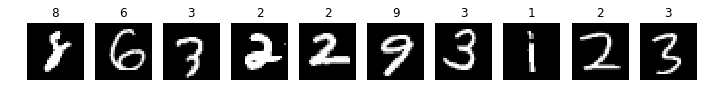

In [12]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP


In order to classify MNIST data using MLP, we start by flattening image data as a vector and its label to a one-hot vector. By doing this we could make input x with 784-dimension and the output y with 10-dimension. 

In [13]:
# Flatten the images to have input as 784 dimension
trainX = [np.concatenate(x) for x in train_images]
testX = [np.concatenate(x) for x in test_images]
print('The size of each training data is now {}'.format(len(trainX[0])))
print('The size of each testing data is now {}'.format(len(testX[0])))

The size of each training data is now 784
The size of each testing data is now 784


In [14]:
trainY = np.eye(10)[train_labels]
testY = np.eye(10)[test_labels]

print('The training label is now one hot vector with size {}'.format(len(trainY[0])))
print('The testing label is now one hot vector with size {}'.format(len(testY[0])))

The training label is now one hot vector with size 10
The testing label is now one hot vector with size 10


### 1. Using basic tutorial from sklearn

In [15]:
from sklearn.neural_network import MLPClassifier

We first tried to see how MLP is implemented using sklearn package. 'MLPClassifier' implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.

We used 'lbfgs' as a solver and it is an optimizer of quasi-Newton methods. This solver approximates the Hessian matrix which represents the second-order partial derivative of a function. Further it approximates the inverse of the Hessian matrix to perform parameter updates. The activation functions of the hidden units that we used were relu which returns $relu(x) = man(x,0)$ The hidden layer sizes were set to (100, ) so that it can automatically do multi-classification which in our cases are 10 classes.  


In [16]:
# Build a MLP network
model1 = MLPClassifier(solver='lbfgs', alpha=1e-3,
                       hidden_layer_sizes=(100, ),
                       max_iter = 300, 
                       random_state=7)

# Train a model using training set
model1.fit(trainX, trainY)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [17]:
# Predict labels of test set
predictedY = model1.predict(testX)

# Convert ong-hot vector to numbers
predicted_label =[np.argmax(k) for k in predictedY]

# Calculate the error rate
success_rate = np.sum((test_labels == predicted_label).astype(np.int))/len(test_labels)
print('The error rate on the test set is {:.3f}'.format(1-success_rate))

The error rate on the test set is 0.075


This time, instead of using 'lbfgs' as an optimzer, we tried to use Adam as an optimizer here.  The other parameters are set equally.

Adam stands for ADAptive Momentum estimate. It is one of the alternatives of stochastic gradient descent algorithm which updates the learning rate adaptively by itself for each parameters. It computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients, it also keeps an exponentially decaying average of past gradients similar to momentum.

In [18]:
# Build a MLP network
model2 = MLPClassifier(solver='adam', alpha=1e-3,
                       hidden_layer_sizes=(100, ),
                       max_iter = 300, 
                       random_state=7)

# Train a model using training set
model2.fit(trainX, trainY)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [19]:
# Predict labels of test set
predictedY2 = model2.predict(testX)

# Convert ong-hot vector to numbers
predicted_label2 =[np.argmax(k) for k in predictedY2]

# Calculate the error rate
success_rate = np.sum((test_labels == predicted_label2).astype(np.int))/len(test_labels)
print('The error rate on the test set is {:.3f}'.format(1-success_rate))

The error rate on the test set is 0.048


The result was better when 'adam' was used as an optimizer though it takes much longer time than using 'lbfgs'. 


### 2. Using TensorFlow

In [20]:
import tensorflow as tf

C:\Users\shgold\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In order to better understand the structure of MLP, we decided to use TensorFlow to build a network. 

We made several layers in the network; an input layer, two hidden layers and an output layers. We have 784 input pixels which we indicate with $x$(input layer), 100 h1 neurons(layer1), 100 h2 neurons(layer2) and 10 output neurons(output layer). For each hidden layer the following computation will be made.

- Hidden Layer 1 : $h1 = g(W_{1} x + b_{1})$   where $W_{1}$ is a matrix with size [784,100]
- Hidden Layer 2 : $h2 = g(W_{2} h1 + b_{2})$   where $W_{2}$ is a matrix with size [100,100]
- Output Layer   : $out =f(W_{3} h2 + b_{3})$   where $W_{3}$ is a matrix with size [100,10]

The function g is an activation function and we have set it to 'relu' since it gives better result than 'sigmoid' or 'tanh'. 

We have also defined a loss function as a softmax cross-entropy with logits since this dataset has more than two classes. For the optimizer we used Adam optimizer. 


In [25]:
# Define a Network
# NETWORK TOPOLOGIES
lr = 0.0025 # Learning rate


# INPUTS Layer
x = tf.placeholder(tf.float32, [None, 784])

# HIDDEN Layer1 
W1 = tf.Variable(tf.random_normal([784, 100]))
b1 = tf.Variable(tf.random_normal([100]))
layer1 = tf.nn.relu(tf.add(tf.matmul(x, W1), b1)) 

# HIDDEN Layer2
W2 = tf.Variable(tf.random_normal([100, 100]))
b2 = tf.Variable(tf.random_normal([100]))
layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, W2), b2)) 

# OUTPUT Layer
W3 = tf.Variable(tf.random_normal([100, 10]))
b3 = tf.Variable(tf.random_normal([10]))
pred = tf.matmul(layer2, W3) + b3

# OUTPUT holder
y = tf.placeholder(tf.float32, [None, 10])    
    
# LOSS
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)) 

# OPTIMIZER
optim = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss) 

# CORRECT RATE
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ('The function is ready..')

The function is ready..


Before training the network with training dataset, we defined a function called 'next_batch' which chooses n random data and its corresponding labels. We sought to implement a mini-batch technique while traning. Mini-batch learning can be understood as applying batch gradient descent to smaller subsets of the training data, for example, 100 samples at a time. The advantage of using mini-batch technique is that the convergence reaches faster because of the more frequent weight updates. 

In [22]:
def next_batch(num, data, labels):
    '''
    Choose the n random data and its corresponding labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [ data[i] for i in idx ]
    labels_shuffle = [ labels[i] for i in idx ]
    #labels_shuffle = np.eye(10)[np.asarray(labels_)]
    

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

Now, we trained our data with 500 iteration with batch size of 100. The learning rate was set to 0.0025. 
While training, we printed out the error rate on trianing set and test set for every 10th iterations.

In [23]:
# PARAMETERS
training_epochs = 500
batch_size      = 100
display_step    = 10

# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)

# OPTIMIZE
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(len(test_images)/batch_size)
    
    # ITERATION
    for i in range(total_batch):
        batch_x, batch_y = next_batch(batch_size, trainX, trainY)
        feeds = {x: batch_x, y: batch_y}
        sess.run(optim, feed_dict=feeds)
        avg_loss += sess.run(loss, feed_dict=feeds)
    
    
    avg_loss = avg_loss / total_batch
    
    # DISPLAY
    if (epoch+5) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_loss))
        feeds = {x: batch_x, y: batch_y}
        train_acc = sess.run(accr, feed_dict=feeds)
        print ("The error rate of training set is: %.3f" % (1-train_acc))
        test_batch_x, test_batch_y = next_batch(len(test_images), testX, testY)
        feeds = {x: test_batch_x, y: test_batch_y}
        test_acc = sess.run(accr, feed_dict=feeds)
        print ("The error rate of test set is: %.3f" % (1-test_acc))
print ("Optimization is Finished...")

Epoch: 005/500 cost: 311477.787265625
The error rate of training set is: 0.140
The error rate of test set is: 0.150
Epoch: 015/500 cost: 113912.853906250
The error rate of training set is: 0.040
The error rate of test set is: 0.106
Epoch: 025/500 cost: 51752.113007812
The error rate of training set is: 0.040
The error rate of test set is: 0.092
Epoch: 035/500 cost: 39500.240605469
The error rate of training set is: 0.040
The error rate of test set is: 0.078
Epoch: 045/500 cost: 22271.855180664
The error rate of training set is: 0.070
The error rate of test set is: 0.073
Epoch: 055/500 cost: 17177.975175781
The error rate of training set is: 0.040
The error rate of test set is: 0.073
Epoch: 065/500 cost: 10593.254305420
The error rate of training set is: 0.010
The error rate of test set is: 0.067
Epoch: 075/500 cost: 7084.852376404
The error rate of training set is: 0.010
The error rate of test set is: 0.063
Epoch: 085/500 cost: 5762.572514782
The error rate of training set is: 0.010
Th

In [24]:
# Print the final result after training the network
train_batch_x, train_batch_y = next_batch(len(train_images), trainX, trainY)
feeds = {x: train_batch_x, y: train_batch_y}
train_acc = sess.run(accr, feed_dict=feeds)
print('The final error rate of the prediected value on training set is {:.3f}'.format(1-train_acc))
test_batch_x, test_batch_y = next_batch(len(test_images), testX, testY)
feeds = {x: test_batch_x, y: test_batch_y}
test_acc = sess.run(accr, feed_dict=feeds)
print('The final error rate of the prediected value on testing set is {:.3f}'.format(1-test_acc))

The final error rate of the prediected value on training set is 0.004
The final error rate of the prediected value on testing set is 0.033


Finally, the error rate on the training set is almost close to zero from the 100th iteraton which means that the network is overfitted to the training set. The error rate on test set using MLP network is higher than training set and it is around between 0.03 and 0.04 due to the randomness of the weights and biases of each layer. Since we only used linear functions for the network, the accuracy rate that we could achieve is limited. If we use convolutional method, we can achieve much better accruacy rate. 